In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import * 

In [2]:
df = pd.read_csv("data_clean_features.csv")
cols = df.columns.tolist()
# let us remove some columns that we do not need NON NUMERIC
DROP_COLS = [
    "blob_url",
    "RowKey",
    "PartitionKey",
    "name",
    "serialization_method",
    "qpy_serialization_success",
    "gate_counts",
    "automatic_method"
]
FEATURES = df.drop(columns=DROP_COLS).columns.tolist()
print(len(df))

195932


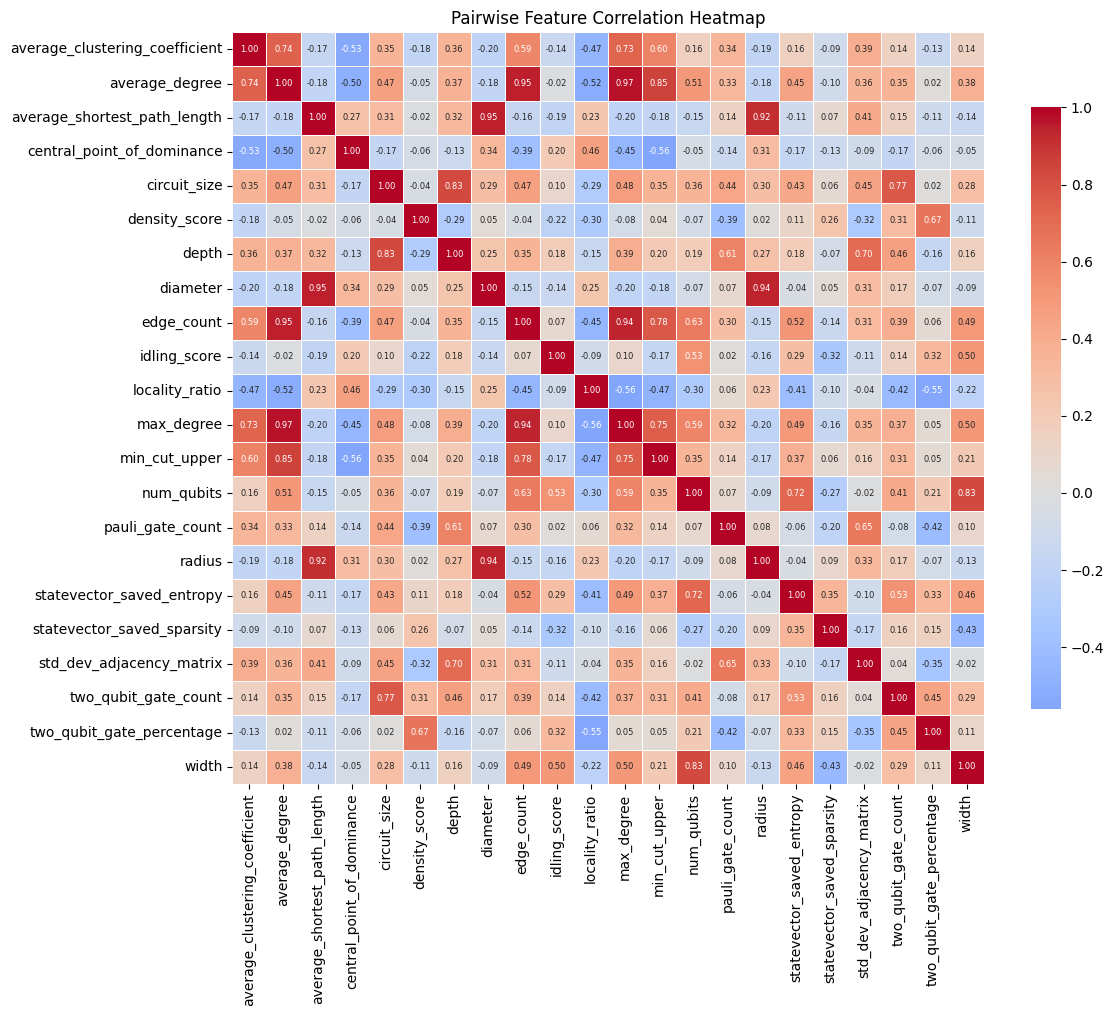

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only
df_num = df.select_dtypes(include="number")

# Compute correlation matrix
corr = df_num.corr(method="pearson")

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot=True,          # <-- show values
    fmt=".2f",           # 2 decimal places
    annot_kws={"size": 6}  # small text
)

plt.title("Pairwise Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


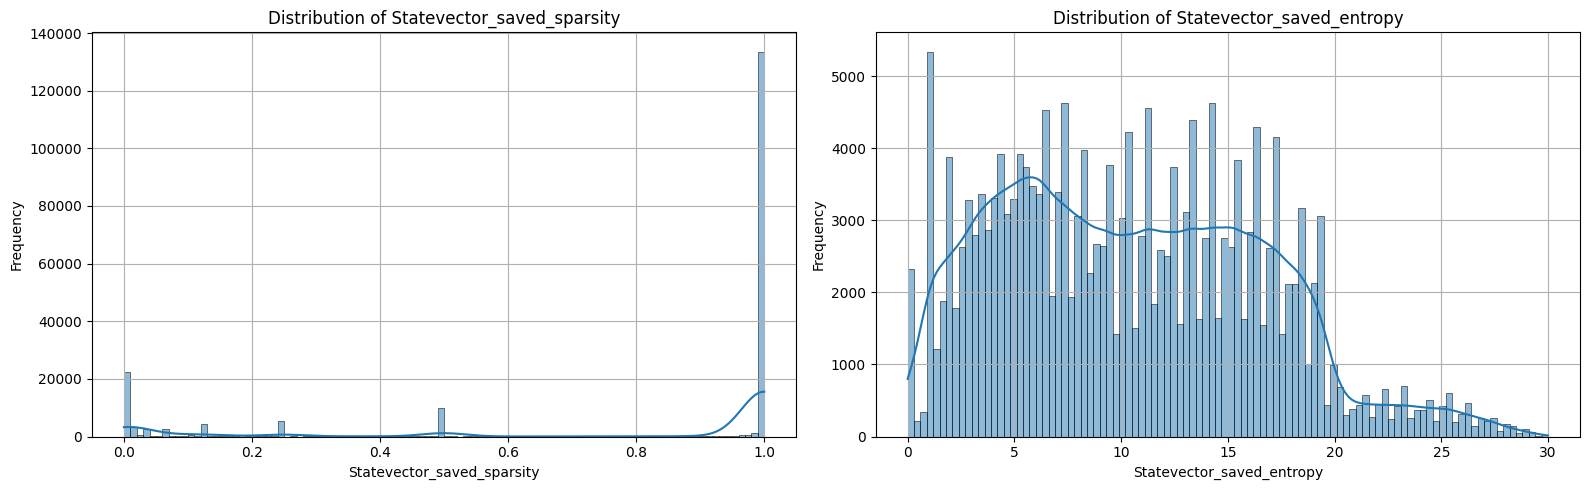

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ["statevector_saved_sparsity", "statevector_saved_entropy"]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, feature in zip(axes, features):
    sns.histplot(df[feature], bins=100, kde=True, ax=ax)
    ax.set_title(f"Distribution of {feature.capitalize()}")
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel("Frequency")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [5]:
# Let us train a regression model to estimate sparsity and entropy.
from sklearn.model_selection import train_test_split

TARGET_SPARSITY = "statevector_saved_sparsity"
TARGET_ENTROPY = "statevector_saved_entropy"
FEATURES_CLEAN = [
    f for f in FEATURES
    if f not in [TARGET_ENTROPY, TARGET_SPARSITY]
]
X = df[FEATURES_CLEAN]
y_sparsity = df[TARGET_SPARSITY]
y_entropy = df[TARGET_ENTROPY]

X_train, X_test, y_s_train, y_s_test, y_e_train, y_e_test = train_test_split(
    X, y_sparsity, y_entropy,
    test_size=0.2,
    random_state=42
)
print(len(X), len(X_train), len(X_test))
print(X_train.columns.tolist())

195932 156745 39187
['average_clustering_coefficient', 'average_degree', 'average_shortest_path_length', 'central_point_of_dominance', 'circuit_size', 'density_score', 'depth', 'diameter', 'edge_count', 'idling_score', 'locality_ratio', 'max_degree', 'min_cut_upper', 'num_qubits', 'pauli_gate_count', 'radius', 'std_dev_adjacency_matrix', 'two_qubit_gate_count', 'two_qubit_gate_percentage', 'width']


In [6]:
from sklearn.ensemble import RandomForestRegressor

sparsity_model = RandomForestRegressor(
    n_estimators=100,      # ↓ from 300
    max_depth=15,          # LIMIT depth
    min_samples_leaf=5,    # prevent overfitting
    random_state=42,
    n_jobs=-1
)

entropy_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

sparsity_model.fit(X_train, y_s_train)
entropy_model.fit(X_train, y_e_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",15
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [7]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name}")
    print(f"  R²   : {r2_score(y_test, y_pred):.4f}")
    print(f"  RMSE : {rmse:.4f}")
    print()

evaluate(sparsity_model, X_test, y_s_test, "Sparsity Model")
evaluate(entropy_model, X_test, y_e_test, "Entropy Model")


Sparsity Model
  R²   : 0.7574
  RMSE : 0.1960

Entropy Model
  R²   : 0.8890
  RMSE : 2.0521



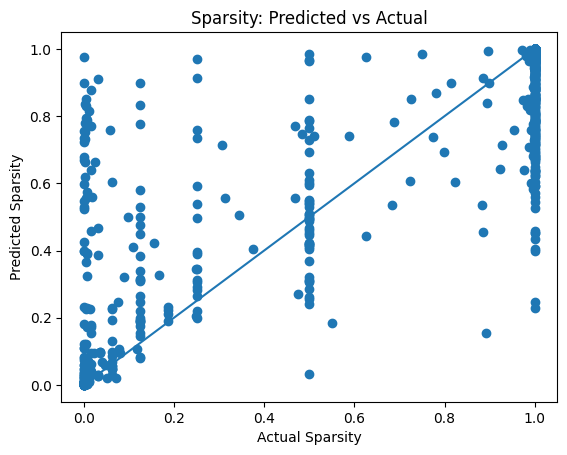

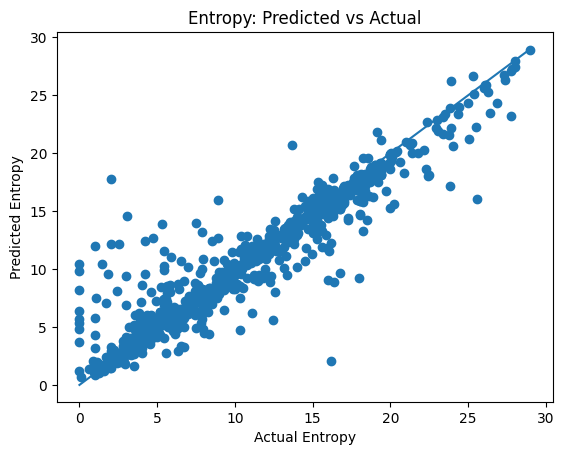

In [8]:
plotn = 1000
new_X = X_test.iloc[:plotn]

sparsity_pred = sparsity_model.predict(new_X)
entropy_pred = entropy_model.predict(new_X)

actual_sparsity = y_s_test.iloc[:plotn]
actual_entropy = y_e_test.iloc[:plotn]

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(actual_sparsity, sparsity_pred)
plt.plot(
    [actual_sparsity.min(), actual_sparsity.max()],
    [actual_sparsity.min(), actual_sparsity.max()]
)
plt.xlabel("Actual Sparsity")
plt.ylabel("Predicted Sparsity")
plt.title("Sparsity: Predicted vs Actual")
plt.show()

plt.figure()
plt.scatter(actual_entropy, entropy_pred)
plt.plot(
    [actual_entropy.min(), actual_entropy.max()],
    [actual_entropy.min(), actual_entropy.max()]
)
plt.xlabel("Actual Entropy")
plt.ylabel("Predicted Entropy")
plt.title("Entropy: Predicted vs Actual")
plt.show()


# Sparsity Bin Classifier

In [9]:
bins = [
    0.0,
    0.1,
    0.2,
    0.4,  
    0.6,  
    1.01  
]

# bins = [0.0, 0.5, 0.6, 1.01]

labels = [str(bins[i])+ "-" + str(bins[i+1]) for i in range(len(bins)-1)]

df["sparsity_bin"] = pd.cut(
    df["statevector_saved_sparsity"],
    bins=bins,
    labels=labels,
    include_lowest=True
)


In [10]:
from sklearn.model_selection import train_test_split

X = df[FEATURES_CLEAN]
y = df["sparsity_bin"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

In [11]:
from sklearn.ensemble import RandomForestClassifier

modelSparsityClassifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=200,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

modelSparsityClassifier.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",200
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [12]:
from sklearn.metrics import classification_report

y_pred = modelSparsityClassifier.predict(X_test)

print(
    classification_report(
        y_test,
        y_pred,
        digits=3
    )
)

              precision    recall  f1-score   support

     0.0-0.1      0.712     0.750     0.730      8201
     0.1-0.2      0.246     0.509     0.332      1475
     0.2-0.4      0.226     0.409     0.291      1714
     0.4-0.6      0.282     0.593     0.382      2728
    0.6-1.01      0.964     0.787     0.867     34865

    accuracy                          0.748     48983
   macro avg      0.486     0.609     0.520     48983
weighted avg      0.836     0.748     0.781     48983



In [13]:
bin_counts = df["sparsity_bin"].value_counts().sort_index()
total = bin_counts.sum()

print("Sparsity bin counts:")
for label, count in bin_counts.items():
    pct = 100 * count / total
    print(f"{label:10s}: {count:8d}  ({pct:6.2f}%)")


Sparsity bin counts:
0.0-0.1   :    32803  ( 16.74%)
0.1-0.2   :     5902  (  3.01%)
0.2-0.4   :     6858  (  3.50%)
0.4-0.6   :    10911  (  5.57%)
0.6-1.01  :   139458  ( 71.18%)


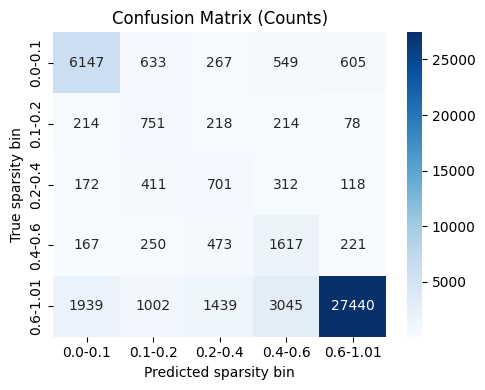

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = modelSparsityClassifier.classes_

cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted sparsity bin")
plt.ylabel("True sparsity bin")
plt.title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

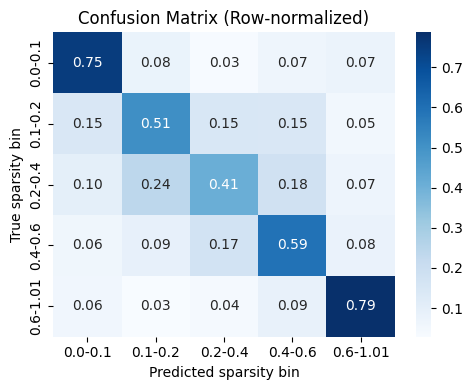

In [15]:
cm_norm = confusion_matrix(
    y_test,
    y_pred,
    labels=labels,
    normalize="true"
)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted sparsity bin")
plt.ylabel("True sparsity bin")
plt.title("Confusion Matrix (Row-normalized)")
plt.tight_layout()
plt.show()


In [16]:
importance = pd.Series(
    modelSparsityClassifier.feature_importances_,
    index=FEATURES_CLEAN
).sort_values(ascending=False)

importance.head(20)

pauli_gate_count                  0.123249
std_dev_adjacency_matrix          0.096800
density_score                     0.081239
idling_score                      0.080470
average_shortest_path_length      0.059412
two_qubit_gate_percentage         0.054859
min_cut_upper                     0.049576
num_qubits                        0.046570
central_point_of_dominance        0.045864
radius                            0.044821
average_clustering_coefficient    0.043523
width                             0.042719
average_degree                    0.042101
two_qubit_gate_count              0.037555
circuit_size                      0.034687
diameter                          0.034114
locality_ratio                    0.025691
depth                             0.022185
edge_count                        0.022011
max_degree                        0.012554
dtype: float64